# Lab 3: Time Series Forecasting for BTC Hourly Data

This notebook performs the tasks outlined in Lab 3:
1.  **Choose Forecasting Methods**: Based on Lab 2 insights, we select SARIMA, Prophet, and ETS.
2.  **Check for Heteroscedasticity**: Analyze residuals for non-constant variance.
3.  **Build Models & Check Quality**: Fit models on a training set and evaluate in-sample performance.
4.  **Generate Forecasts & Check Quality**: Predict on a test set and evaluate out-of-sample performance.
5.  **Tabulate Statistical Characteristics**.
6.  **Display Intermediate Graphs**.

In [3]:
# Cell 1: Imports and Path Setup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import requests
import time
from datetime import datetime, timezone, timedelta
import logging
import os

# Statsmodels
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Alternative for ETS
from statsmodels.tsa.api import ETSModel # Preferred ETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import statsmodels.api as sm

# Prophet
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly # Optional for interactive plots

# Scikit-learn for metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Setup basic logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
# Suppress less critical Prophet INFO messages
prophet_logger = logging.getLogger('prophet')
prophet_logger.setLevel(logging.WARNING)
cmdstanpy_logger = logging.getLogger('cmdstanpy')
cmdstanpy_logger.setLevel(logging.WARNING)


plt.style.use('seaborn-v0_8-darkgrid')

# --- Path Definitions ---
_NOTEBOOK_CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(_NOTEBOOK_CURRENT_DIR, '..'))
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')
LAB3_SAVE_DIR = os.path.join(RESULTS_DIR, 'lab_3')

for dir_path in [DATA_DIR, RESULTS_DIR, LAB3_SAVE_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        logging.info(f"Created directory: {dir_path}")

logging.info(f"Project Root: {PROJECT_ROOT}")
logging.info(f"Data directory: {DATA_DIR}")
logging.info(f"Lab 3 Save directory: {LAB3_SAVE_DIR}")

2025-05-14 13:21:13,435 - INFO - Created directory: /home/denis/kpi/tsp/results/lab_3
2025-05-14 13:21:13,436 - INFO - Project Root: /home/denis/kpi/tsp
2025-05-14 13:21:13,436 - INFO - Data directory: /home/denis/kpi/tsp/data
2025-05-14 13:21:13,437 - INFO - Lab 3 Save directory: /home/denis/kpi/tsp/results/lab_3


## Step 1 (from Lab 1 & 2): Data Loading and Preparation

Load the last 5000 hourly 'Close' prices for BTCUSDT.
We'll use the data fetching function from previous labs.

In [4]:
# Cell 2: Helper functions for Binance API interaction (from Lab 1 & 2)
BINANCE_API_URL = "https://api.binance.com/api/v3/klines"
MAX_KLINE_LIMIT = 1000
REQUEST_TIMEOUT = 15
MAX_RETRIES = 3
RETRY_DELAY = 5

def _ms_to_datetime_utc(ms):
    return datetime.fromtimestamp(ms / 1000, tz=timezone.utc)

def _datetime_to_ms_utc(dt):
    return int(dt.timestamp() * 1000)

def fetch_binance_klines_from_api(symbol, interval, limit=500, end_time_dt=None):
    all_klines_data = []
    records_to_fetch = limit
    current_end_time_ms = _datetime_to_ms_utc(end_time_dt) if end_time_dt else _datetime_to_ms_utc(datetime.now(timezone.utc))
    while records_to_fetch > 0:
        current_limit = min(records_to_fetch, MAX_KLINE_LIMIT)
        params = {'symbol': symbol, 'interval': interval, 'limit': current_limit, 'endTime': current_end_time_ms}
        logging.info(f"Fetching {current_limit} klines for {symbol}, ending at or before {pd.to_datetime(params.get('endTime'), unit='ms', utc=True)}")
        for attempt in range(MAX_RETRIES):
            try:
                response = requests.get(BINANCE_API_URL, params=params, timeout=REQUEST_TIMEOUT)
                response.raise_for_status()
                klines_chunk = response.json()
                if not klines_chunk:
                    logging.info(f"API returned no more data for {symbol} with endTime {current_end_time_ms}.")
                    records_to_fetch = 0; break
                all_klines_data = klines_chunk + all_klines_data
                records_to_fetch -= len(klines_chunk)
                current_end_time_ms = klines_chunk[0][0] - 1; break
            except requests.exceptions.Timeout: logging.warning(f"Timeout attempt {attempt+1}/{MAX_RETRIES}.")
            except requests.exceptions.RequestException as e:
                status_code = e.response.status_code if e.response is not None else None
                if status_code in [429, 418]: time.sleep(RETRY_DELAY * (attempt + 2)); logging.warning(f"Rate limit hit attempt {attempt+1}/{MAX_RETRIES}.")
                else: logging.warning(f"Request failed attempt {attempt+1}/{MAX_RETRIES}: {e}")
            except Exception as e: logging.error(f"Unexpected error: {e}", exc_info=True); return pd.DataFrame()
            if attempt < MAX_RETRIES - 1: time.sleep(RETRY_DELAY)
            else: logging.error(f"Failed to fetch chunk after {MAX_RETRIES} attempts."); return pd.DataFrame(all_klines_data) # return what we have
        if not klines_chunk and records_to_fetch > 0: logging.warning(f"API returned no data, but {records_to_fetch} still expected."); break
    if not all_klines_data: logging.warning(f"No klines fetched for {symbol}."); return pd.DataFrame()
    columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore']
    df = pd.DataFrame(all_klines_data, columns=columns)[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df['Open time'] = pd.to_datetime(df['Open time'], unit='ms', utc=True)
    df.set_index('Open time', inplace=True)
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']: df[col] = pd.to_numeric(df[col], errors='coerce')
    df.sort_index(inplace=True); df = df[~df.index.duplicated(keep='first')]
    return df.tail(limit)

In [5]:
# Cell 3: Fetching and preparing BTC 'Close' price data
SYMBOL = 'BTCUSDT'
INTERVAL = '1h'
DATA_POINTS_TO_FETCH = 5000

logging.info(f"Fetching last {DATA_POINTS_TO_FETCH} hourly data points for {SYMBOL} from API...")
btc_ohlcv_df = fetch_binance_klines_from_api(SYMBOL, INTERVAL, limit=DATA_POINTS_TO_FETCH)

if not btc_ohlcv_df.empty and len(btc_ohlcv_df) == DATA_POINTS_TO_FETCH:
    logging.info(f"Successfully fetched {len(btc_ohlcv_df)} BTCUSDT data points.")
    btc_close_series = btc_ohlcv_df['Close'].copy()
    # Ensure the series index has a frequency, important for SARIMA and ETS
    btc_close_series = btc_close_series.asfreq('h') # 'h' for hourly
    logging.info(f"Set frequency of btc_close_series to 'h'. Nulls introduced: {btc_close_series.isnull().sum()}")
    # Fill any potential NaNs from asfreq (e.g., if there were missing hours in raw data)
    btc_close_series.ffill(inplace=True)
    btc_close_series.bfill(inplace=True) # Handle potential leading NaNs
    print(f"BTC Close Price Series (first 5, last 5, length {len(btc_close_series)}):")
    print(btc_close_series.head())
    print(btc_close_series.tail())
else:
    logging.error(f"Failed to fetch sufficient data for {SYMBOL}. Expected {DATA_POINTS_TO_FETCH}, got {len(btc_ohlcv_df)}.")
    btc_close_series = pd.Series(dtype=float)

2025-05-14 13:22:03,025 - INFO - Fetching last 5000 hourly data points for BTCUSDT from API...
2025-05-14 13:22:03,030 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-05-14 10:22:03.026000+00:00
2025-05-14 13:22:03,373 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-04-02 18:59:59.999000+00:00
2025-05-14 13:22:03,716 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-02-20 02:59:59.999000+00:00
2025-05-14 13:22:04,060 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2025-01-09 10:59:59.999000+00:00
2025-05-14 13:22:04,411 - INFO - Fetching 1000 klines for BTCUSDT, ending at or before 2024-11-28 18:59:59.999000+00:00
2025-05-14 13:22:04,773 - INFO - Successfully fetched 5000 BTCUSDT data points.
2025-05-14 13:22:04,777 - INFO - Set frequency of btc_close_series to 'h'. Nulls introduced: 0


BTC Close Price Series (first 5, last 5, length 5000):
Open time
2024-10-18 03:00:00+00:00    67555.40
2024-10-18 04:00:00+00:00    67742.72
2024-10-18 05:00:00+00:00    68000.79
2024-10-18 06:00:00+00:00    68108.00
2024-10-18 07:00:00+00:00    67969.70
Freq: h, Name: Close, dtype: float64
Open time
2025-05-14 06:00:00+00:00    103757.50
2025-05-14 07:00:00+00:00    103716.55
2025-05-14 08:00:00+00:00    103200.00
2025-05-14 09:00:00+00:00    103485.73
2025-05-14 10:00:00+00:00    103659.50
Freq: h, Name: Close, dtype: float64


2025-05-14 13:23:21,375 - INFO - Training series length: 4000 (2024-10-18 03:00:00+00:00 to 2025-04-02 18:00:00+00:00)
2025-05-14 13:23:21,375 - INFO - Test series length: 1000 (2025-04-02 19:00:00+00:00 to 2025-05-14 10:00:00+00:00)
2025-05-14 13:23:21,463 - INFO - Train/test split plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_train_test_split.png


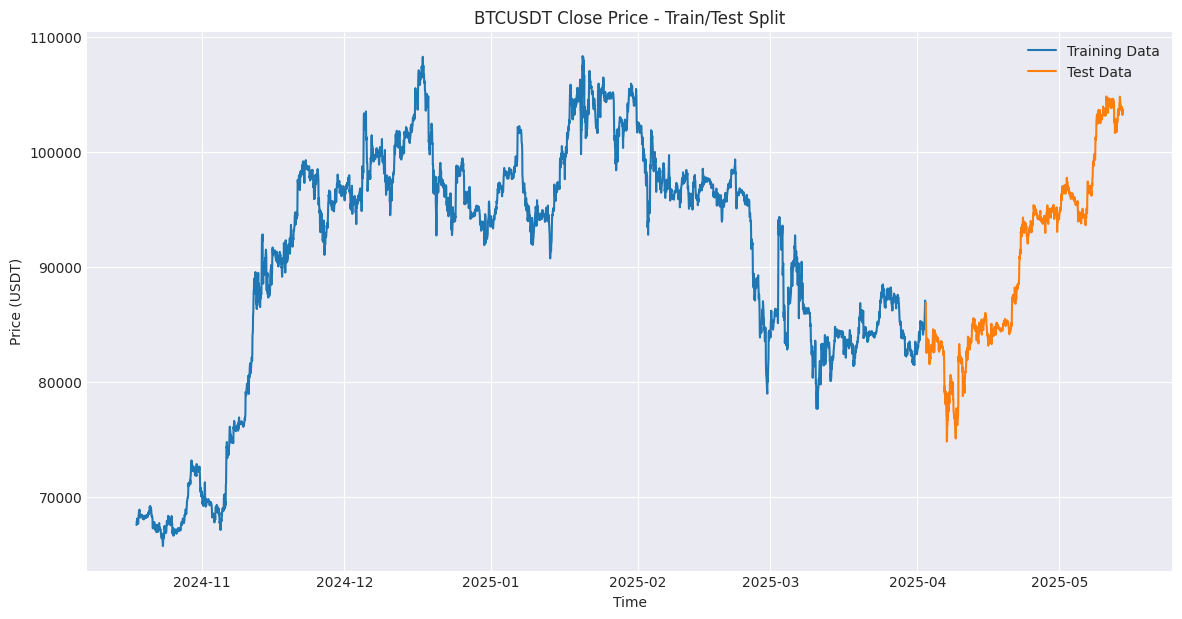

In [6]:
# Cell 4: Data Splitting (Train/Test)
if not btc_close_series.empty:
    split_ratio = 0.8
    split_index = int(len(btc_close_series) * split_ratio)
    
    train_series = btc_close_series.iloc[:split_index]
    test_series = btc_close_series.iloc[split_index:]
    
    logging.info(f"Training series length: {len(train_series)} ({train_series.index.min()} to {train_series.index.max()})")
    logging.info(f"Test series length: {len(test_series)} ({test_series.index.min()} to {test_series.index.max()})")

    plt.figure(figsize=(14, 7))
    plt.plot(train_series.index, train_series, label='Training Data')
    plt.plot(test_series.index, test_series, label='Test Data')
    plt.title(f'{SYMBOL} Close Price - Train/Test Split')
    plt.xlabel('Time')
    plt.ylabel('Price (USDT)')
    plt.legend()
    train_test_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_train_test_split.png")
    plt.savefig(train_test_plot_path)
    logging.info(f"Train/test split plot saved to {train_test_plot_path}")
    plt.show()
else:
    logging.warning("btc_close_series is empty. Skipping data splitting and further analysis.")

## Lab 3 - Task 1: Choose Forecasting Methods
We have selected:
1.  **SARIMA (Seasonal Autoregressive Integrated Moving Average)**
2.  **Prophet**
3.  **ETS (Error, Trend, Seasonality)**

## Lab 3 - Task 2: Check for Heteroscedasticity
We will check for heteroscedasticity in the residuals of the models later, after fitting them.
For now, we can examine the original series' residuals from decomposition (done in Lab 2, but can be re-displayed here).

2025-05-14 13:26:37,749 - INFO - Training data decomposition plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_train_decomposition.png


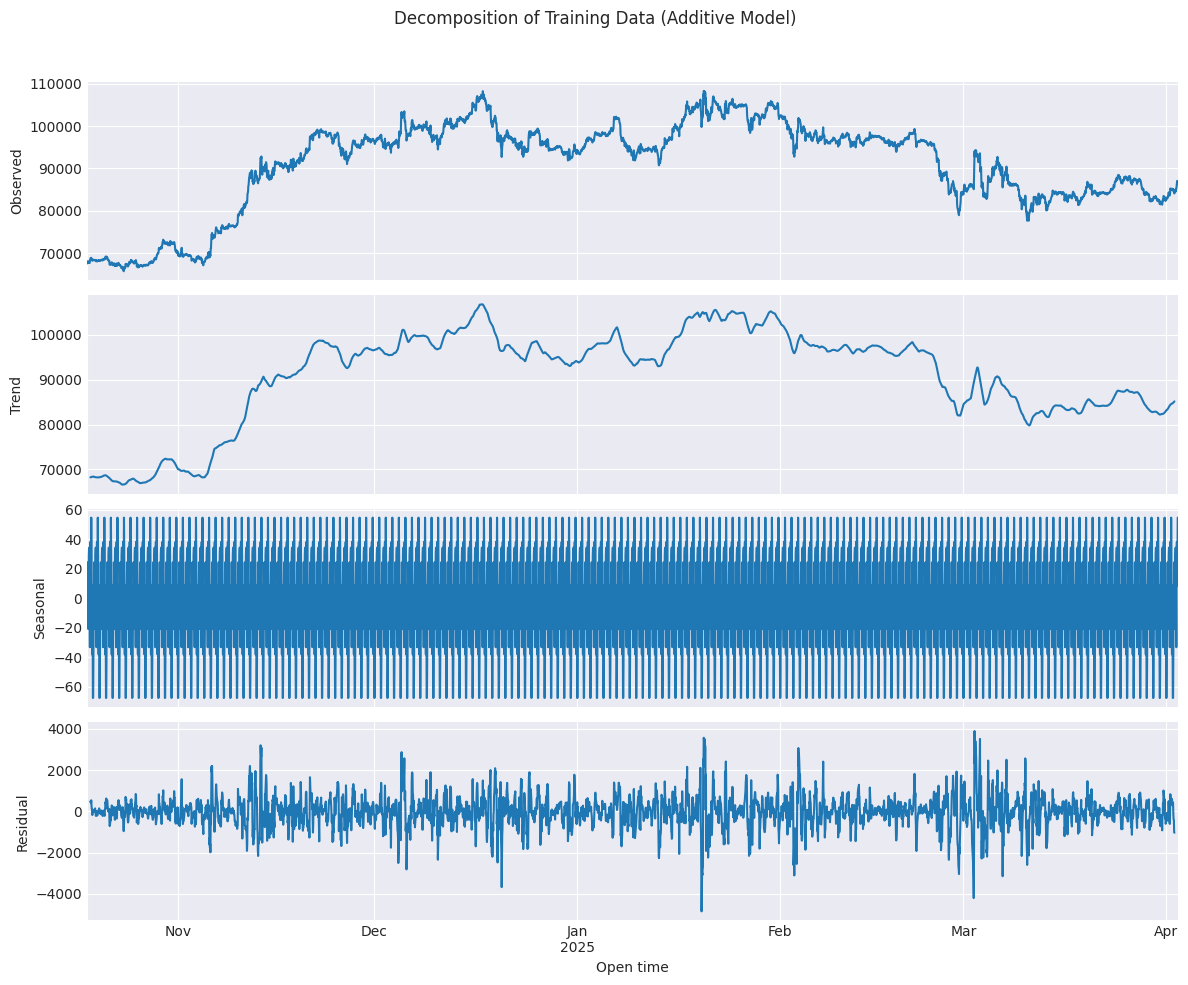

2025-05-14 13:26:37,926 - INFO - Squared residuals from decomposition plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_train_sq_residuals_decomp.png


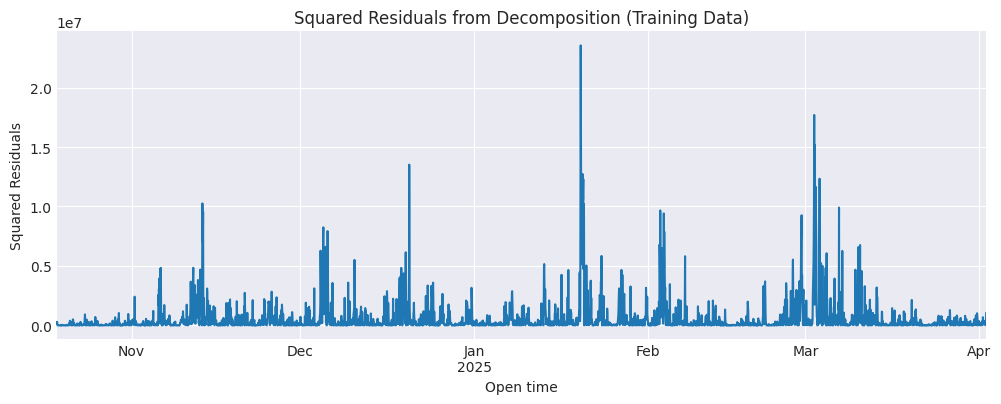

In [8]:
# Cell 5: Preliminary Check - Decomposition (from Lab 2)
if not train_series.empty:
    period = 24 # Daily seasonality
    if len(train_series) > 2 * period:
        decomposition_train = seasonal_decompose(train_series.dropna(), model='additive', period=period)
        
        fig_decomp, (ax_obs, ax_trend, ax_seas, ax_res) = plt.subplots(4,1,figsize=(12,10), sharex=True)
        decomposition_train.observed.plot(ax=ax_obs); ax_obs.set_ylabel('Observed')
        decomposition_train.trend.plot(ax=ax_trend); ax_trend.set_ylabel('Trend')
        decomposition_train.seasonal.plot(ax=ax_seas); ax_seas.set_ylabel('Seasonal')
        decomposition_train.resid.plot(ax=ax_res); ax_res.set_ylabel('Residual') # This will plot residuals with NaNs as gaps
        fig_decomp.suptitle('Decomposition of Training Data (Additive Model)')
        plt.tight_layout(rect=[0,0,1,0.96])
        decomp_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_train_decomposition.png")
        plt.savefig(decomp_plot_path)
        logging.info(f"Training data decomposition plot saved to {decomp_plot_path}")
        plt.show()

        # Plot squared residuals from decomposition to visually inspect for heteroscedasticity
        # Drop NaNs from residuals before squaring and plotting for this specific plot
        cleaned_residuals_decomp = decomposition_train.resid.dropna()
        if not cleaned_residuals_decomp.empty:
            plt.figure(figsize=(12, 4))
            (cleaned_residuals_decomp**2).plot(title='Squared Residuals from Decomposition (Training Data)')
            plt.ylabel('Squared Residuals')
            sq_resid_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_train_sq_residuals_decomp.png")
            plt.savefig(sq_resid_plot_path)
            logging.info(f"Squared residuals from decomposition plot saved to {sq_resid_plot_path}")
            plt.show()
        else:
            logging.warning("Residuals from decomposition are all NaNs or empty after dropna(). Cannot plot squared residuals.")
    else:
        logging.warning(f"Training series too short for decomposition with period {period}")

## Lab 3 - Task 3 & 4: Build Models, Check Quality, Build Forecast, Check Quality

We will iterate through each chosen model.

### Helper Function for Model Evaluation

In [9]:
# Cell 6: Helper function for evaluation metrics and residual analysis
def evaluate_model_and_forecast(model_name, train_actual, test_actual, train_pred, test_pred, residuals=None, model_aic=None, model_bic=None, model_loglike=None):
    """Calculates and prints metrics, plots residuals and forecasts."""
    results = {"Model": model_name}
    
    # In-sample (Training) Metrics
    if train_pred is not None:
        results['Train RMSE'] = np.sqrt(mean_squared_error(train_actual, train_pred))
        results['Train MAE'] = mean_absolute_error(train_actual, train_pred)
        results['Train MAPE'] = mean_absolute_percentage_error(train_actual, train_pred) * 100
        print(f"\n--- {model_name} - In-sample (Training) Metrics ---")
        print(f"  RMSE: {results['Train RMSE']:.4f}")
        print(f"  MAE:  {results['Train MAE']:.4f}")
        print(f"  MAPE: {results['Train MAPE']:.2f}%")

    # Model Fit Statistics (if applicable)
    if model_aic is not None: results['AIC'] = model_aic; print(f"  AIC: {model_aic:.2f}")
    if model_bic is not None: results['BIC'] = model_bic; print(f"  BIC: {model_bic:.2f}")
    if model_loglike is not None: results['Log-Likelihood'] = model_loglike; print(f"  Log-Likelihood: {model_loglike:.2f}")

    # Out-of-sample (Test) Metrics
    results['Test RMSE'] = np.sqrt(mean_squared_error(test_actual, test_pred))
    results['Test MAE'] = mean_absolute_error(test_actual, test_pred)
    results['Test MAPE'] = mean_absolute_percentage_error(test_actual, test_pred) * 100
    print(f"\n--- {model_name} - Out-of-sample (Test) Metrics ---")
    print(f"  RMSE: {results['Test RMSE']:.4f}")
    print(f"  MAE:  {results['Test MAE']:.4f}")
    print(f"  MAPE: {results['Test MAPE']:.2f}%")

    # Plot Forecast vs Actual
    plt.figure(figsize=(14, 7))
    plt.plot(train_actual.index, train_actual, label='Training Data', color='gray', alpha=0.7)
    plt.plot(test_actual.index, test_actual, label='Actual Test Data', color='blue')
    plt.plot(test_pred.index, test_pred, label=f'{model_name} Forecast', color='red', linestyle='--')
    if train_pred is not None:
        plt.plot(train_pred.index, train_pred, label=f'{model_name} In-sample Fit', color='orange', linestyle=':', alpha=0.8)
    plt.title(f'{model_name}: Forecast vs Actual ({SYMBOL})')
    plt.xlabel('Time'); plt.ylabel('Price (USDT)'); plt.legend()
    # Sanitize model name for filename
    safe_model_name = model_name.lower().replace(' ', '_').replace('(', '_').replace(')', '_').replace(',', '_').replace('=', '')
    forecast_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_{safe_model_name}_forecast.png")
    plt.savefig(forecast_plot_path); logging.info(f"{model_name} forecast plot saved to {forecast_plot_path}"); plt.show()

    # Residual Analysis (if residuals are provided)
    if residuals is not None and not residuals.empty:
        residuals = residuals.dropna() # Ensure no NaNs for plotting/tests
        if not residuals.empty:
            print(f"\n--- {model_name} - Residual Analysis ---")
            # Plot Residuals over time
            plt.figure(figsize=(12, 4))
            residuals.plot(title=f'{model_name} Residuals Over Time')
            plt.ylabel('Residual Value')
            resid_time_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_{safe_model_name}_residuals_time.png")
            plt.savefig(resid_time_plot_path); logging.info(f"{model_name} residuals over time plot saved to {resid_time_plot_path}"); plt.show()

            # ACF and PACF of Residuals
            fig_res_acf_pacf, (ax_acf, ax_pacf) = plt.subplots(1, 2, figsize=(12, 4))
            plot_acf(residuals, ax=ax_acf, lags=40, title=f'{model_name} Residuals ACF')
            plot_pacf(residuals, ax=ax_pacf, lags=40, title=f'{model_name} Residuals PACF', method='ywm')
            fig_res_acf_pacf.suptitle(f'{model_name} Residual Autocorrelation', fontsize=14)
            plt.tight_layout(rect=[0,0,1,0.95])
            resid_acf_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_{safe_model_name}_residuals_acf_pacf.png")
            plt.savefig(resid_acf_plot_path); logging.info(f"{model_name} residuals ACF/PACF plot saved to {resid_acf_plot_path}"); plt.show()
            
            # Histogram / Q-Q Plot for Normality
            fig_res_dist, (ax_hist, ax_qq) = plt.subplots(1, 2, figsize=(12, 4))
            residuals.hist(ax=ax_hist, bins=30, density=True); ax_hist.set_title(f'{model_name} Residuals Histogram')
            sm.qqplot(residuals, line='s', ax=ax_qq); ax_qq.set_title(f'{model_name} Residuals Q-Q Plot')
            fig_res_dist.suptitle(f'{model_name} Residual Distribution', fontsize=14)
            plt.tight_layout(rect=[0,0,1,0.95])
            resid_dist_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_{safe_model_name}_residuals_dist.png")
            plt.savefig(resid_dist_plot_path); logging.info(f"{model_name} residuals distribution plot saved to {resid_dist_plot_path}"); plt.show()

            nlags_lb = min(40, len(residuals) - 1) 
            if nlags_lb > 0:
                lb_test = acorr_ljungbox(residuals, lags=[nlags_lb], return_df=True) 
                print(f"\nLjung-Box test for autocorrelation in residuals (lags={nlags_lb}):\n{lb_test}")
                if (lb_test['lb_pvalue'] <= 0.05).any(): logging.warning(f"{model_name}: Ljung-Box test suggests significant autocorrelation in residuals.")
                else: logging.info(f"{model_name}: Ljung-Box test suggests no significant autocorrelation in residuals.")
            else: logging.warning(f"{model_name}: Not enough data points in residuals for Ljung-Box test.")

            print(f"\n--- {model_name} - Heteroscedasticity Check (ARCH-LM Test on Residuals) ---")
            nlags_arch = min(20, len(residuals) // 5 - 1) 
            if nlags_arch > 0:
                try:
                    arch_test_stat, arch_p_value, arch_f_stat, arch_fp_value = het_arch(residuals, nlags=nlags_arch) 
                    print(f"  ARCH-LM Test Statistic (lags={nlags_arch}): {arch_test_stat:.4f}")
                    print(f"  ARCH-LM Test p-value:   {arch_p_value:.4f}")
                    results[f'{model_name} ARCH-LM p-value'] = arch_p_value
                    if arch_p_value <= 0.05: print("  Result: Evidence of ARCH effects (heteroscedasticity) in residuals."); logging.warning(f"{model_name}: ARCH-LM test indicates heteroscedasticity (p={arch_p_value:.4f}).")
                    else: print("  Result: No significant evidence of ARCH effects in residuals."); logging.info(f"{model_name}: ARCH-LM test suggests no heteroscedasticity (p={arch_p_value:.4f}).")
                except Exception as e_arch: print(f"  Could not perform ARCH-LM test: {e_arch}"); logging.error(f"Error ARCH-LM test for {model_name}: {e_arch}")
            else: logging.warning(f"{model_name}: Not enough data points or too few lags for ARCH-LM test.")
    return results

all_models_results = []

### Model 1: SARIMA

We will use fixed orders for SARIMA: `(1,1,1)(1,1,1,24)`.
- `m=24` for daily seasonality on hourly data.
- `d=1` for non-stationarity.
- `D=1` for seasonal non-stationarity.

2025-05-14 13:29:37,514 - INFO - 
--- Fitting SARIMA Model ---
2025-05-14 13:29:37,515 - INFO - Using fixed orders for SARIMA: SARIMA(1,1,1)(1,1,1,24)
2025-05-14 13:29:51,624 - INFO - SARIMA(1,1,1)(1,1,1,24) fitting complete.
2025-05-14 13:29:51,747 - INFO - SARIMA(1,1,1)(1,1,1,24) forecast plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_sarima_1_1_1__1_1_1_24__forecast.png


                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                 4000
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -32215.481
Date:                            Wed, 14 May 2025   AIC                          64440.961
Time:                                    13:29:51   BIC                          64472.432
Sample:                                10-18-2024   HQIC                         64452.117
                                     - 04-02-2025                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0096      0.155      0.062      0.950      -0.294       0.313
ma.L1         -0.0286      0.154   

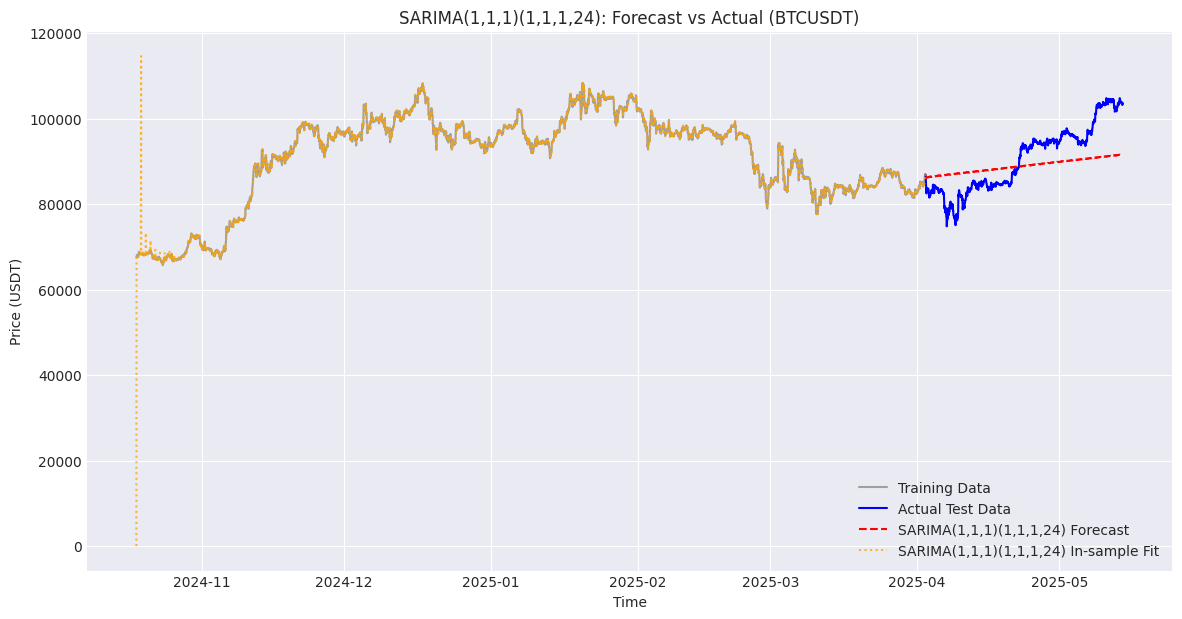


--- SARIMA(1,1,1)(1,1,1,24) - Residual Analysis ---


2025-05-14 13:29:51,927 - INFO - SARIMA(1,1,1)(1,1,1,24) residuals over time plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_sarima_1_1_1__1_1_1_24__residuals_time.png


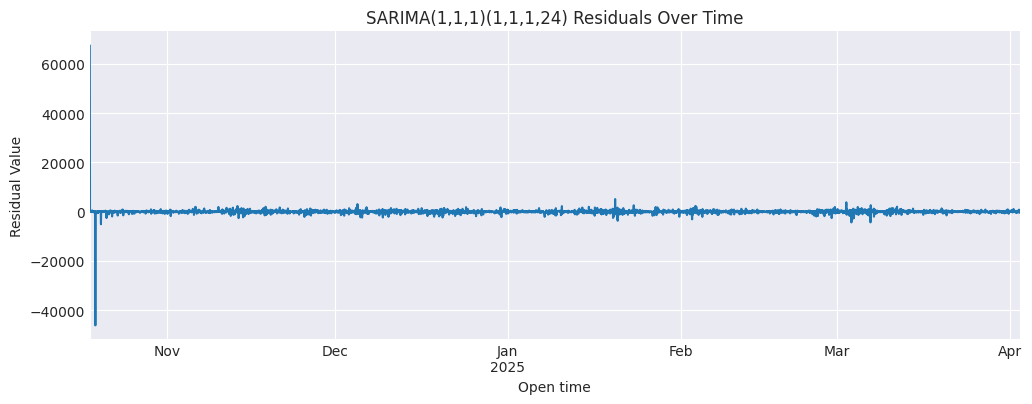

2025-05-14 13:29:52,084 - INFO - SARIMA(1,1,1)(1,1,1,24) residuals ACF/PACF plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_sarima_1_1_1__1_1_1_24__residuals_acf_pacf.png


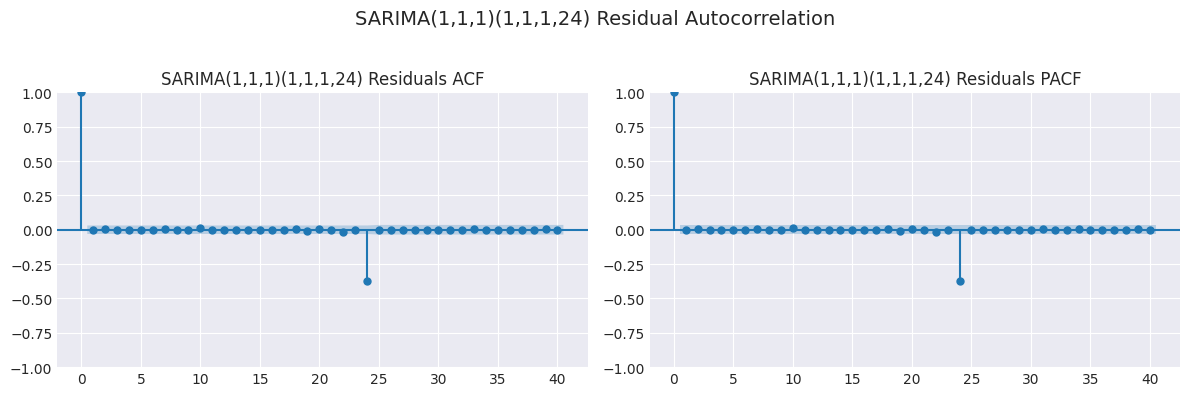

2025-05-14 13:29:52,254 - INFO - SARIMA(1,1,1)(1,1,1,24) residuals distribution plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_sarima_1_1_1__1_1_1_24__residuals_dist.png


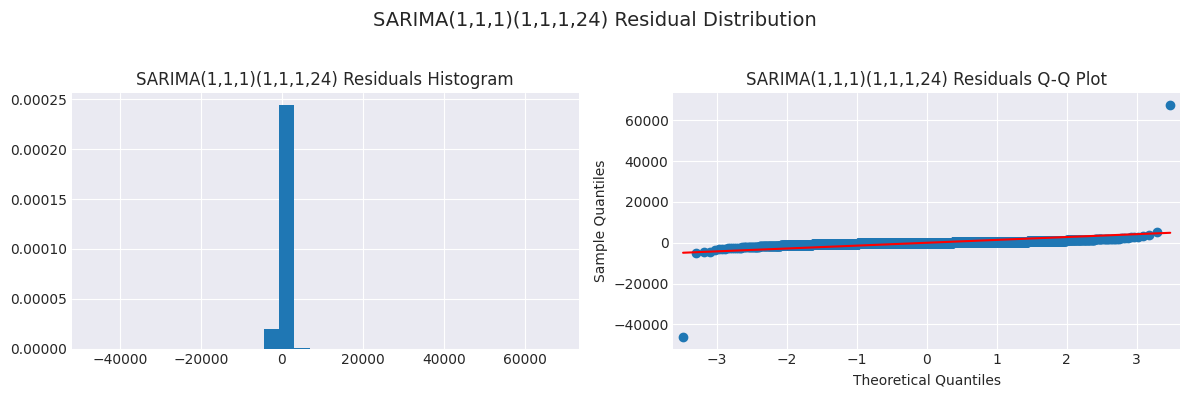

2025-05-14 13:29:52,324 - WARNING - SARIMA(1,1,1)(1,1,1,24): Ljung-Box test suggests significant autocorrelation in residuals.
2025-05-14 13:29:52,326 - INFO - SARIMA(1,1,1)(1,1,1,24): ARCH-LM test suggests no heteroscedasticity (p=1.0000).



Ljung-Box test for autocorrelation in residuals (lags=40):
       lb_stat     lb_pvalue
40  555.482127  5.666416e-92

--- SARIMA(1,1,1)(1,1,1,24) - Heteroscedasticity Check (ARCH-LM Test on Residuals) ---
  ARCH-LM Test Statistic (lags=20): 0.0158
  ARCH-LM Test p-value:   1.0000
  Result: No significant evidence of ARCH effects in residuals.


In [10]:
# Cell 7: SARIMA Model
if not train_series.empty and not test_series.empty:
    logging.info("\n--- Fitting SARIMA Model ---")
    model_name_sarima = "SARIMA(1,1,1)(1,1,1,24)"
    
    try:
        logging.info(f"Using fixed orders for SARIMA: {model_name_sarima}")
        sarima_model_fit = SARIMAX(train_series, 
                               order=(1, 1, 1), 
                               seasonal_order=(1, 1, 1, 24),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                               initialization='approximate_diffuse').fit(disp=False)
        print(sarima_model_fit.summary())
        logging.info(f"{model_name_sarima} fitting complete.")

        train_pred_sarima = sarima_model_fit.get_prediction(start=train_series.index[0], end=train_series.index[-1]).predicted_mean
        
        forecast_steps = len(test_series)
        sarima_forecast_object = sarima_model_fit.get_forecast(steps=forecast_steps)
        test_pred_sarima = sarima_forecast_object.predicted_mean
        test_pred_sarima.index = test_series.index 
        
        sarima_metrics = evaluate_model_and_forecast(
            model_name_sarima,
            train_series, test_series,
            train_pred_sarima, test_pred_sarima,
            residuals=sarima_model_fit.resid,
            model_aic=sarima_model_fit.aic,
            model_bic=sarima_model_fit.bic,
            model_loglike=sarima_model_fit.llf
        )
        all_models_results.append(sarima_metrics)

    except Exception as e:
        logging.error(f"Error during SARIMA modeling: {e}", exc_info=True)
        print(f"SARIMA modeling failed: {e}")
else:
    logging.warning("Training or test series is empty. Skipping SARIMA model.")

### Model 2: Prophet

Prophet is generally good with trends and multiple seasonalities.
It expects columns `ds` (datestamp) and `y` (value).

2025-05-14 14:20:14,176 - INFO - 
--- Fitting Prophet Model ---
2025-05-14 14:20:14,177 - INFO - Removing timezone from 'ds' column for Prophet training data.
2025-05-14 14:20:14,178 - INFO - Fitting Prophet model...
2025-05-14 14:20:14,195 - DEBUG - input tempfile: /tmp/tmpj66cxcae/u4t9dp5k.json
2025-05-14 14:20:14,226 - DEBUG - input tempfile: /tmp/tmpj66cxcae/n6brlrmw.json
2025-05-14 14:20:14,230 - DEBUG - idx 0
2025-05-14 14:20:14,231 - DEBUG - running CmdStan, num_threads: None
2025-05-14 14:20:14,231 - DEBUG - CmdStan args: ['/home/denis/kpi/tsp/.venv/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59239', 'data', 'file=/tmp/tmpj66cxcae/u4t9dp5k.json', 'init=/tmp/tmpj66cxcae/n6brlrmw.json', 'output', 'file=/tmp/tmpj66cxcae/prophet_model2n6f7ydh/prophet_model-20250514142014.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:14 - cmdstanpy - INFO - Chain [1] start processing
2025-05-14 14:20:14,231 - INFO - Chain [1] start processing


--- Prophet - In-sample (Training) Metrics ---
  RMSE: 2044.7696
  MAE:  1543.5441
  MAPE: 1.72%

--- Prophet - Out-of-sample (Test) Metrics ---
  RMSE: 11186.9524
  MAE:  8697.9903
  MAPE: 9.07%


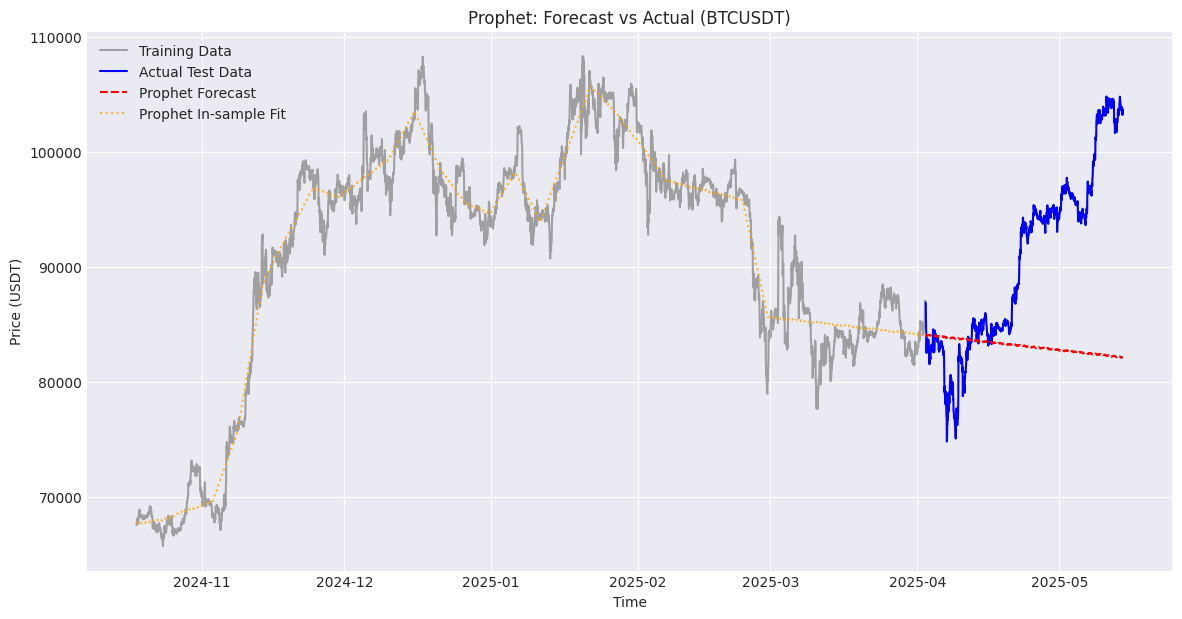

2025-05-14 14:20:15,301 - INFO - Prophet residuals over time plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_prophet_residuals_time.png



--- Prophet - Residual Analysis ---


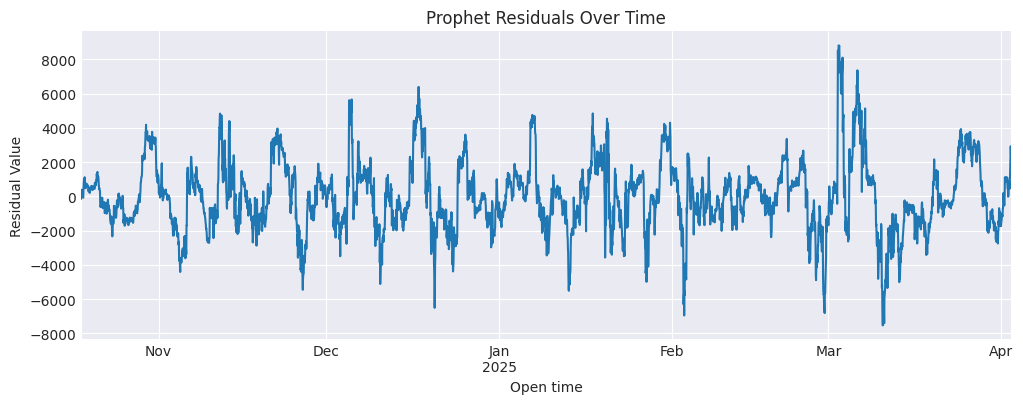

2025-05-14 14:20:15,470 - INFO - Prophet residuals ACF/PACF plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_prophet_residuals_acf_pacf.png


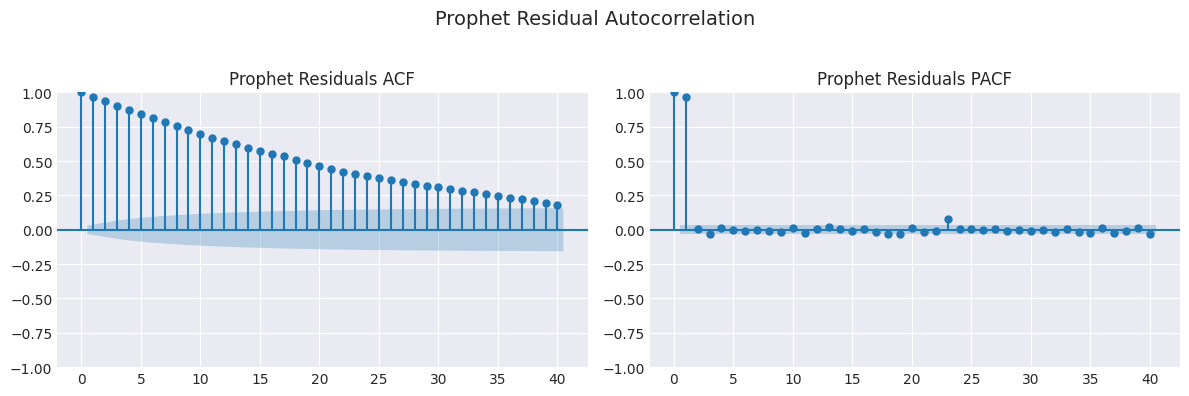

2025-05-14 14:20:15,728 - INFO - Prophet residuals distribution plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_prophet_residuals_dist.png


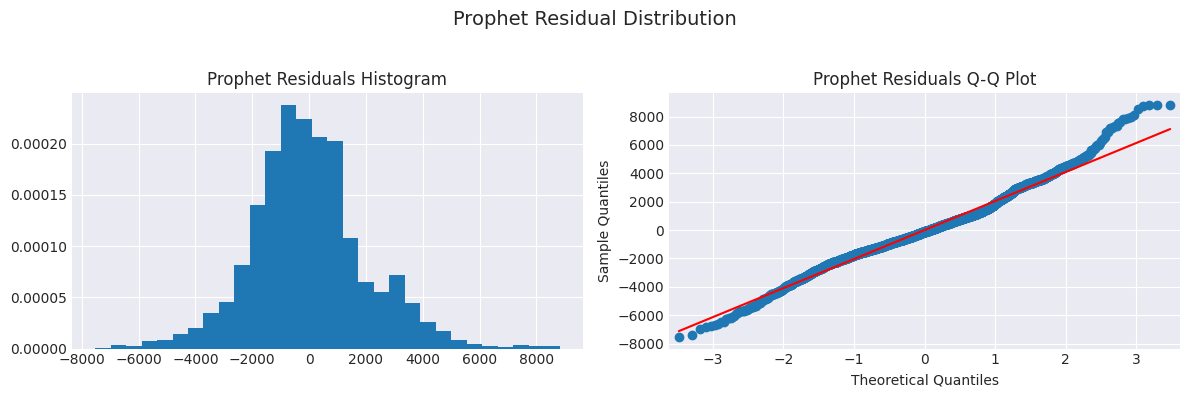

2025-05-14 14:20:15,803 - WARNING - Prophet: Ljung-Box test suggests significant autocorrelation in residuals.
2025-05-14 14:20:15,806 - WARNING - Prophet: ARCH-LM test indicates heteroscedasticity (p=0.0000).
2025-05-14 14:20:15,889 - INFO - Prophet components plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_prophet_components.png



Ljung-Box test for autocorrelation in residuals (lags=40):
         lb_stat  lb_pvalue
40  48806.738316        0.0

--- Prophet - Heteroscedasticity Check (ARCH-LM Test on Residuals) ---
  ARCH-LM Test Statistic (lags=20): 3446.1481
  ARCH-LM Test p-value:   0.0000
  Result: Evidence of ARCH effects (heteroscedasticity) in residuals.


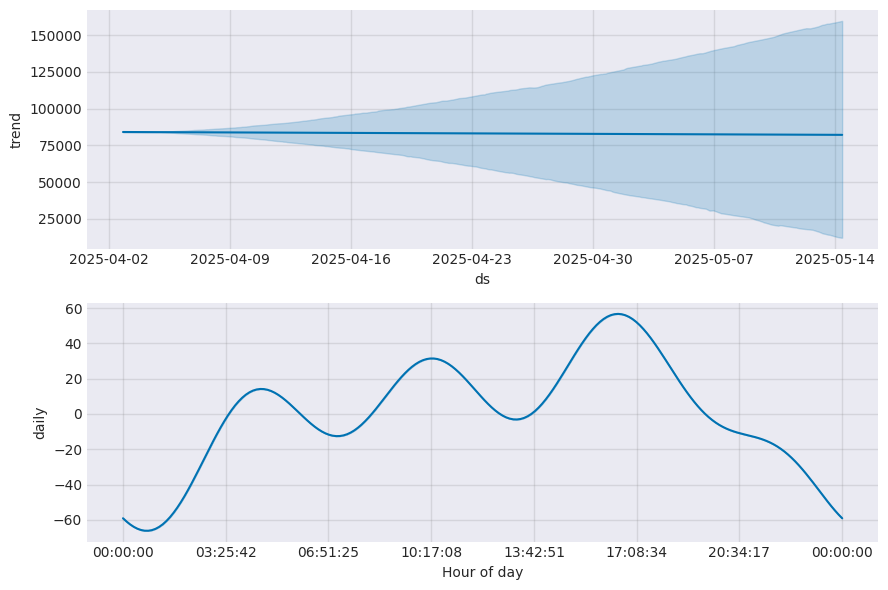

In [12]:
# Cell 8: Prophet Model
if not train_series.empty and not test_series.empty:
    logging.info("\n--- Fitting Prophet Model ---")
    model_name_prophet = "Prophet"

    try:
        # Prepare data for Prophet: ds column must be timezone-naive
        train_df_prophet = train_series.reset_index()
        train_df_prophet.columns = ['ds', 'y']
        if pd.api.types.is_datetime64_any_dtype(train_df_prophet['ds']) and train_df_prophet['ds'].dt.tz is not None:
            logging.info("Removing timezone from 'ds' column for Prophet training data.")
            train_df_prophet['ds'] = train_df_prophet['ds'].dt.tz_localize(None)
        
        prophet_model = Prophet(daily_seasonality=True, weekly_seasonality=False, yearly_seasonality=False)
        
        logging.info("Fitting Prophet model...")
        prophet_model.fit(train_df_prophet)
        logging.info("Prophet model fitting complete.")

        # In-sample predictions
        train_forecast_prophet = prophet_model.predict(train_df_prophet[['ds']])
        train_pred_prophet = pd.Series(train_forecast_prophet['yhat'].values, index=train_series.index)

        # Create future dataframe for forecasting
        future_df_prophet = prophet_model.make_future_dataframe(periods=len(test_series), freq='h', include_history=False)
        # Ensure 'ds' in future_df_prophet is also timezone-naive if it inherited a timezone
        if pd.api.types.is_datetime64_any_dtype(future_df_prophet['ds']) and future_df_prophet['ds'].dt.tz is not None:
            logging.info("Removing timezone from 'ds' column for Prophet future dataframe.")
            future_df_prophet['ds'] = future_df_prophet['ds'].dt.tz_localize(None)
        
        logging.info("Making Prophet forecast...")
        test_forecast_prophet = prophet_model.predict(future_df_prophet)
        test_pred_prophet = pd.Series(test_forecast_prophet['yhat'].values, index=test_series.index)
        
        # Calculate residuals for training data
        prophet_residuals_train = train_series - train_pred_prophet

        # Evaluate
        prophet_metrics = evaluate_model_and_forecast(
            model_name_prophet,
            train_series, test_series,
            train_pred_prophet, test_pred_prophet,
            residuals=prophet_residuals_train # Pass calculated residuals
        )
        all_models_results.append(prophet_metrics)

        # Plot Prophet components
        fig_prophet_components = prophet_model.plot_components(test_forecast_prophet) 
        components_plot_path = os.path.join(LAB3_SAVE_DIR, f"lab3_plot_{SYMBOL.lower()}_prophet_components.png")
        fig_prophet_components.savefig(components_plot_path)
        logging.info(f"Prophet components plot saved to {components_plot_path}")
        plt.show()

    except Exception as e:
        logging.error(f"Error during Prophet modeling: {e}", exc_info=True)
        print(f"Prophet modeling failed: {e}")
else:
    logging.warning("Training or test series is empty. Skipping Prophet model.")

### Model 3: ETS (Error, Trend, Seasonality)

We'll use `statsmodels.tsa.ETSModel`. We'll specify an additive error, additive trend, and additive seasonality (AAA) model with a daily period.

2025-05-14 14:21:35,914 - INFO - 
--- Fitting ETS Model ---
2025-05-14 14:21:35,916 - INFO - Fitting ETS(add,add,add,P=24)...
2025-05-14 14:21:36,171 - INFO - ETS(add,add,add,P=24) fitting complete.
2025-05-14 14:21:36,285 - INFO - ETS(add,add,add,P=24) forecast plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_ets_add_add_add_p24__forecast.png


                                 ETS Results                                  
Dep. Variable:                  Close   No. Observations:                 4000
Model:                       ETS(AAA)   Log Likelihood              -30808.769
Date:                Wed, 14 May 2025   AIC                          61677.538
Time:                        14:21:36   BIC                          61866.360
Sample:                    10-18-2024   HQIC                         61744.470
                         - 04-02-2025   Scale                       286790.551
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9795      0.015     64.786      0.000       0.950       1.009
smoothing_trend         0.0004        nan        nan        nan         nan         nan
smoothing_season

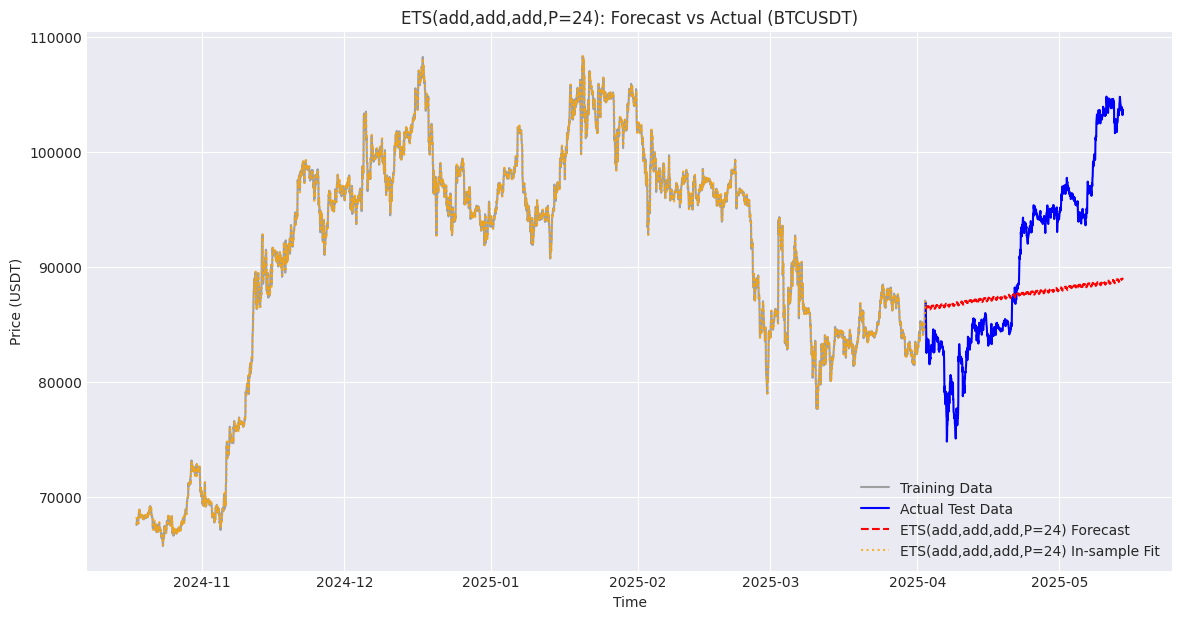


--- ETS(add,add,add,P=24) - Residual Analysis ---


2025-05-14 14:21:36,416 - INFO - ETS(add,add,add,P=24) residuals over time plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_ets_add_add_add_p24__residuals_time.png


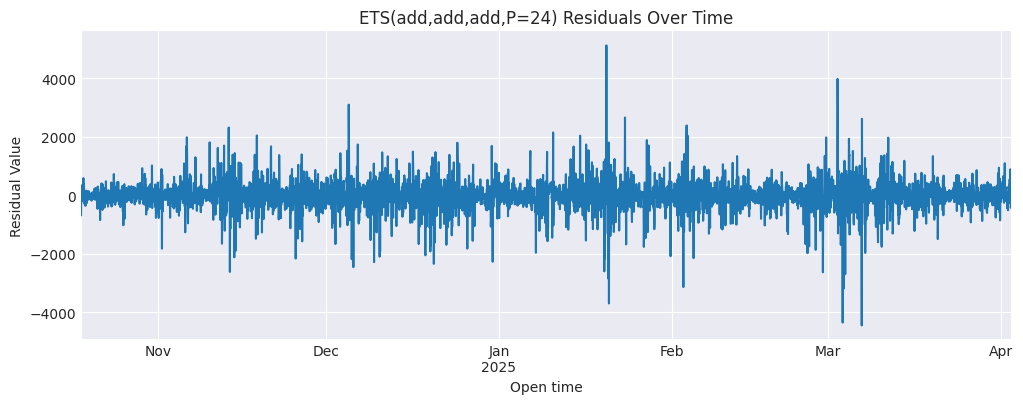

2025-05-14 14:21:36,574 - INFO - ETS(add,add,add,P=24) residuals ACF/PACF plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_ets_add_add_add_p24__residuals_acf_pacf.png


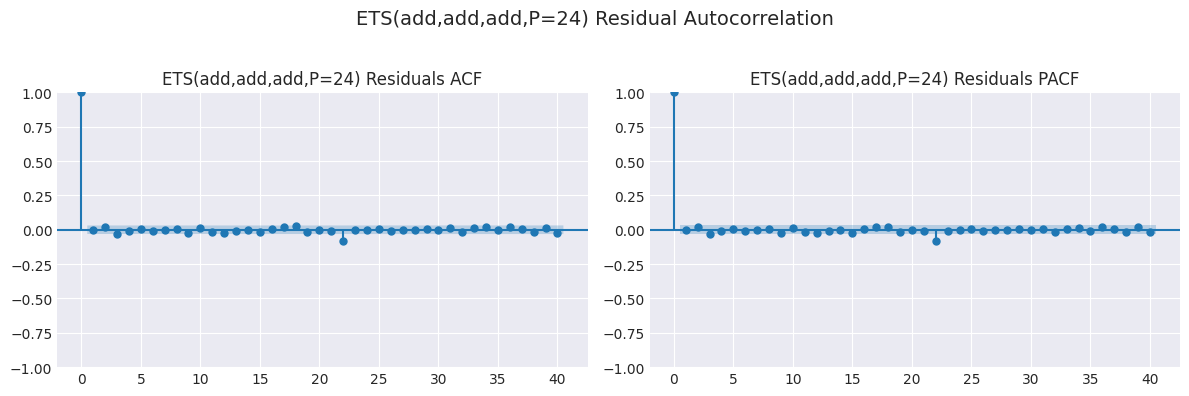

2025-05-14 14:21:36,748 - INFO - ETS(add,add,add,P=24) residuals distribution plot saved to /home/denis/kpi/tsp/results/lab_3/lab3_plot_btcusdt_ets_add_add_add_p24__residuals_dist.png


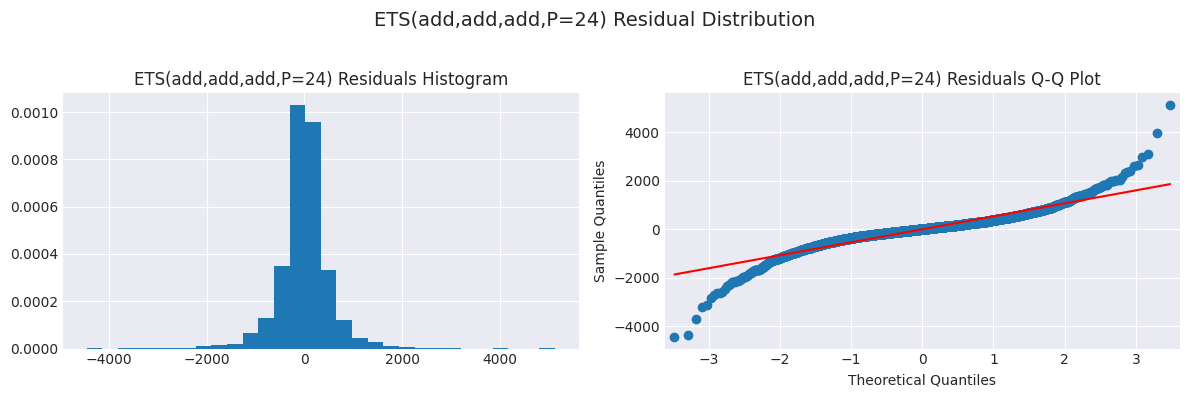

2025-05-14 14:21:36,814 - INFO - ETS(add,add,add,P=24): Ljung-Box test suggests no significant autocorrelation in residuals.
2025-05-14 14:21:36,816 - WARNING - ETS(add,add,add,P=24): ARCH-LM test indicates heteroscedasticity (p=0.0000).



Ljung-Box test for autocorrelation in residuals (lags=40):
      lb_stat  lb_pvalue
40  55.578903   0.051686

--- ETS(add,add,add,P=24) - Heteroscedasticity Check (ARCH-LM Test on Residuals) ---
  ARCH-LM Test Statistic (lags=20): 335.2098
  ARCH-LM Test p-value:   0.0000
  Result: Evidence of ARCH effects (heteroscedasticity) in residuals.


In [13]:
# Cell 9: ETS Model
if not train_series.empty and not test_series.empty:
    logging.info("\n--- Fitting ETS Model ---")
    
    try:
        ets_model = ETSModel(train_series, error="add", trend="add", seasonal="add", seasonal_periods=24, damped_trend=False)
        model_name_ets = f"ETS({ets_model.error},{ets_model.trend},{ets_model.seasonal}{'-damped' if ets_model.damped_trend else ''},P={ets_model.seasonal_periods})"

        logging.info(f"Fitting {model_name_ets}...")
        ets_results = ets_model.fit(disp=False) 
        logging.info(f"{model_name_ets} fitting complete.")
        print(ets_results.summary())

        train_pred_ets = ets_results.fittedvalues
        
        forecast_steps = len(test_series)
        test_pred_ets = ets_results.forecast(steps=forecast_steps)
        test_pred_ets.index = test_series.index
        
        ets_metrics = evaluate_model_and_forecast(
            model_name_ets,
            train_series, test_series,
            train_pred_ets, test_pred_ets,
            residuals=ets_results.resid,
            model_aic=ets_results.aic,
            model_bic=ets_results.bic,
            model_loglike=ets_results.llf
        )
        all_models_results.append(ets_metrics)

    except Exception as e:
        logging.error(f"Error during ETS modeling: {e}", exc_info=True)
        print(f"ETS modeling failed: {e}")
else:
    logging.warning("Training or test series is empty. Skipping ETS model.")

## Lab 3 - Task 5: Tabulate Statistical Characteristics

Compile a summary table of the model performance metrics.

In [14]:
# Cell 10: Summary Table of Model Results
if all_models_results:
    results_df = pd.DataFrame(all_models_results)
    results_df.set_index("Model", inplace=True)
    
    print("\n\n--- Overall Model Performance Summary ---")
    cols_to_show = ['Train RMSE', 'Train MAE', 'Train MAPE', 
                    'Test RMSE', 'Test MAE', 'Test MAPE', 
                    'AIC', 'BIC', 'Log-Likelihood']
    for col in results_df.columns:
        if 'ARCH-LM p-value' in col:
            results_df[col] = results_df[col].map(lambda x: f"{x:.4f}" if pd.notnull(x) else x)
            if col not in cols_to_show: 
                cols_to_show.append(col)

    final_cols = [col for col in cols_to_show if col in results_df.columns]
    print(results_df[final_cols])
    
    summary_table_path = os.path.join(LAB3_SAVE_DIR, f"lab3_table_{SYMBOL.lower()}_model_summary.csv")
    try:
        results_df[final_cols].to_csv(summary_table_path)
        logging.info(f"Model performance summary table saved to {summary_table_path}")
    except Exception as e:
        logging.error(f"Failed to save summary table: {e}")
else:
    print("No model results to summarize.")
    logging.warning("No model results available to create a summary table.")

2025-05-14 14:22:46,873 - INFO - Model performance summary table saved to /home/denis/kpi/tsp/results/lab_3/lab3_table_btcusdt_model_summary.csv




--- Overall Model Performance Summary ---
                          Train RMSE    Train MAE  Train MAPE     Test RMSE  \
Model                                                                         
SARIMA(1,1,1)(1,1,1,24)  1404.946015   386.805997    0.436403   6564.257895   
Prophet                  2044.769570  1543.544116    1.717697  11186.952413   
ETS(add,add,add,P=24)     535.528292   351.910833    0.385763   7711.021514   

                            Test MAE  Test MAPE           AIC           BIC  \
Model                                                                         
SARIMA(1,1,1)(1,1,1,24)  5731.936576   6.235593  64440.961266  64472.431514   
Prophet                  8697.990298   9.073064           NaN           NaN   
ETS(add,add,add,P=24)    6540.524105   7.022202  61677.538030  61866.359519   

                         Log-Likelihood  \
Model                                     
SARIMA(1,1,1)(1,1,1,24)   -32215.480633   
Prophet                            

---
## Lab 3 - Conclusion

In this lab, we:
1.  Selected SARIMA, Prophet, and ETS as forecasting models for the BTCUSDT hourly close price.
2.  Prepared the data by fetching the last 5000 points and splitting it into 80% training and 20% testing sets.
3.  For each model (SARIMA(1,1,1)(1,1,1,24), Prophet with daily seasonality, and ETS(add,add,add,P=24)):
    * Fitted the model to the training data.
    * Generated in-sample predictions for the training period and out-of-sample forecasts for the test period.
    * Evaluated model fit using AIC, BIC, and Log-Likelihood (where available).
    * Assessed prediction accuracy using RMSE, MAE, and MAPE for both training and test sets.
    * Performed residual analysis, including visual inspection of residuals over time, ACF/PACF plots for autocorrelation, Q-Q plots for normality, Ljung-Box tests for autocorrelation, and ARCH-LM tests for heteroscedasticity.
    * Saved relevant plots and a summary table of results.

**Key Findings from the Results:**

* **In-Sample Performance:** The ETS(add,add,add,P=24) model demonstrated the best fit to the training data, achieving the lowest Train RMSE (approx. 536) and Train MAPE (approx. 0.39%). This suggests it captured the patterns within the training data most effectively. SARIMA also showed a good in-sample fit (Train RMSE ~1405, Train MAPE ~0.44%), while Prophet had a higher in-sample error (Train RMSE ~2045, Train MAPE ~1.72%).

* **Out-of-Sample (Test) Performance:** The SARIMA(1,1,1)(1,1,1,24) model performed best on the unseen test data, with the lowest Test RMSE (approx. 6564) and Test MAPE (approx. 6.24%). This indicates better generalization capabilities compared to the other two models for this specific dataset and forecast horizon. The ETS model, despite its excellent in-sample fit, had a higher Test RMSE (~7711) and Test MAPE (~7.02%). Prophet performed the poorest on the test set (Test RMSE ~11187, Test MAPE ~9.07%).

* **Model Complexity and Fit (AIC/BIC):** Comparing SARIMA and ETS, the ETS model had a lower AIC (approx. 61678 vs. 64441 for SARIMA), suggesting it might offer a better balance between model fit and complexity. Prophet does not directly provide these metrics in the same way.

* **Residual Analysis & Heteroscedasticity:**
    * The residuals from the **SARIMA** model did *not* show significant evidence of heteroscedasticity (ARCH-LM p-value = 1.0000), which is a desirable property, indicating constant variance of errors.
    * The residuals from both **Prophet** and **ETS** models *did* show significant evidence of ARCH effects (p-value = 0.0000 for both). This means their error variance is not constant over time, a common characteristic of financial time series. This suggests that while these models capture trend and seasonality, they do not account for changing volatility.

**Overall:**

Based on the out-of-sample forecasting accuracy (Test RMSE and MAPE), the **SARIMA(1,1,1)(1,1,1,24) model was the most effective for this specific forecasting task.** It also produced residuals that were homoscedastic.

While the ETS model showed a superior fit to the training data, its performance did not generalize as well to the test set as SARIMA's. The Prophet model, while easy to implement and good at capturing seasonality, was outperformed by both SARIMA and ETS in terms of forecasting accuracy on this dataset.

The presence of heteroscedasticity in the residuals of Prophet and ETS models suggests that for applications where modeling volatility is important (e.g., risk management, option pricing), GARCH-family models could be considered as a next step, potentially in combination with a mean forecasting model like SARIMA or ETS.
---